# Outline

1. Outline
2. Task
3. Data Extraction
4. Exploratory Analysis
5. Data Preprocessing
6. Model training
7. Result

# Task

This notebook is a part of my project "age_predictor". I will have a front-end where you will be able to upload a picture of yourself, it will then be sent to the back end where pretrained model where the age will be predicted. <br/>
This notebook is responsible for training the model. 

Dataset was collected from here https://susanqq.github.io/UTKFace/

The labels of each face image is embedded in teh file name, formated like <br/> [age] _ [gender] _ [race] _ [ date&time].jpg

# Data Extraction

In [41]:
import os
import random
import re
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers.legacy import Adam

In [2]:
random.seed(2023)

In [3]:
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [4]:
path = './datasets/in_the_wild_faces/'

In [5]:
dir_list = os.listdir(path)

In [6]:
len(dir_list)

24108

In [7]:
df = pd.DataFrame(data=dir_list, columns=['file_name'])

In [8]:
df.sample(3)

,file_name
3010,56_0_2_20170112215424904.jpg
23094,62_0_0_20170117192208082.jpg
8233,25_1_3_20170119172014464.jpg


In [9]:
example = '35_0_3_20170119171318208.jpg'
pattern = r'^(\d+)_(\d+)_(\d+)_(\d+)\.jpg$'
match = re.match(pattern, example)

In [10]:
if match:
    age = match[1]
    gender = match[2]
    race = match[3]
    time = match[4]
    print('age ({}) - gender ({}) - race ({}) - time ({})'.format(
        age, gender, race, time))

age (35) - gender (0) - race (3) - time (20170119171318208)


In [11]:
df['age'] = df.file_name.str.split(pattern).str[1]
df['gender'] = df.file_name.str.split(pattern).str[2]
df['race'] = df.file_name.str.split(pattern).str[3]
df['time'] = df.file_name.str.split(pattern).str[4]

In [12]:
df.head(3)

,file_name,age,gender,race,time
0,26_0_1_20170117200132563.jpg,26,0,1,20170117200132563
1,27_0_1_20170120133818199.jpg,27,0,1,20170120133818199
2,16_1_3_20170104222158160.jpg,16,1,3,20170104222158160


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24108 entries, 0 to 24107
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  24108 non-null  object
 1   age        24101 non-null  object
 2   gender     24101 non-null  object
 3   race       24101 non-null  object
 4   time       24101 non-null  object
dtypes: object(5)
memory usage: 941.8+ KB


In [14]:
def can_convert_to_int(value):
    try:
        int(value)
        return True
    except (ValueError, TypeError):
        return False

In [15]:
age_int_ok = df.age.apply(lambda x: can_convert_to_int(x))

In [16]:
df.age[age_int_ok == False]

4541     NaN
6282     NaN
8242     NaN
9471     NaN
19678    NaN
20596    NaN
21558    NaN
Name: age, dtype: object

In [17]:
df = df[age_int_ok].reset_index(drop=True)

In [18]:
df.age = df.age.astype('int32')

In [19]:
gender_int_ok = df.gender.apply(lambda x: can_convert_to_int(x))

In [20]:
df.gender[gender_int_ok == False]

Series([], Name: gender, dtype: object)

In [21]:
df.gender = df.gender.astype('int32')

In [22]:
race_int_ok = df.race.apply(lambda x: can_convert_to_int(x))

In [23]:
df.race[race_int_ok == False]

Series([], Name: race, dtype: object)

In [24]:
df.race = df.race.astype('int32')

# Exploratory Analysis

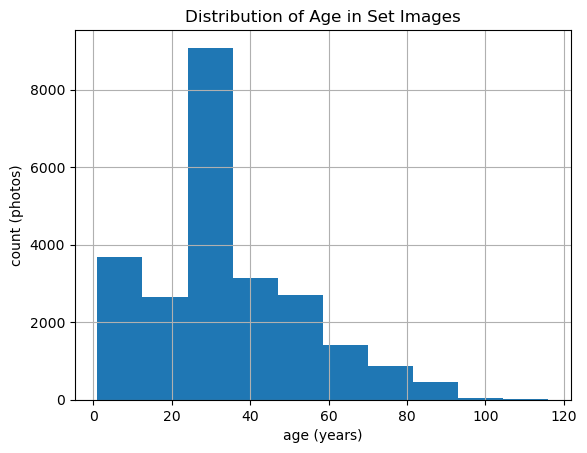

In [32]:
df.age.hist()
plt.xlabel('age (years)')
plt.ylabel('count (photos)')
plt.title('Distribution of Age in Set Images')
plt.show()

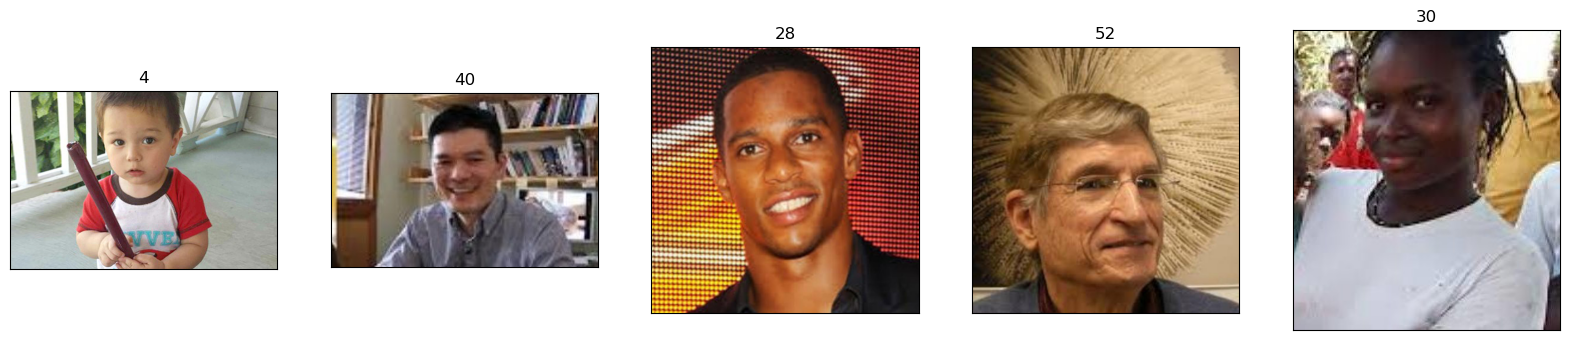

In [33]:
display_images = df.sample(5)

# Create a figure and axes
fig, axes = plt.subplots(ncols=len(display_images), figsize=(20,20))

# Adjust the spacing between plots
plt.subplots_adjust(hspace=1)  # Increase the value to add more space

# Iterate over the data and plot on each axes
for i, ax in enumerate(axes):
    image_data = display_images.iloc[i]
    image = Image.open('./datasets/in_the_wild_faces/' + image_data.file_name)
    image_array = np.array(image)
    ax.imshow(image_array)
    
    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Display real age
    ax.set_title(image_data.age)

# Display the figure
plt.show()

In [34]:
resolution_x = []
resolution_y = []
for file_name in df.sample(100).file_name:
    image = Image.open('./datasets/in_the_wild_faces/' + file_name)
    image_array = np.array(image)
    resolution_x.append(image_array.shape[0])
    resolution_y.append(image_array.shape[1])

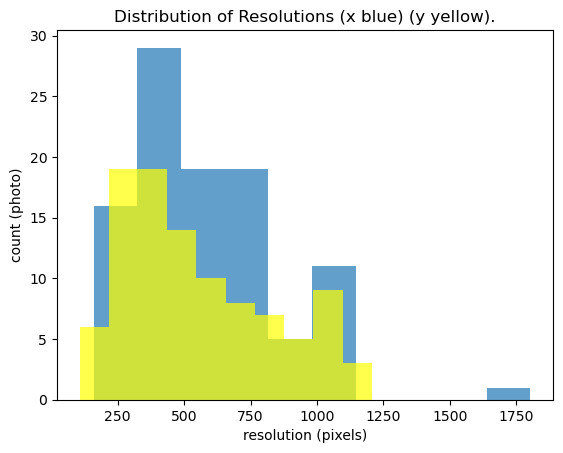

In [35]:
plt.hist(resolution_x, alpha=0.7)
plt.hist(resolution_y, alpha=0.7, color='yellow')
plt.title('Distribution of Resolutions (x blue) (y yellow).')
plt.xlabel('resolution (pixels)')
plt.ylabel('count (photo)')
plt.show()

# Data Preprocessing

In [36]:
data_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.1
    ) 
data_gen_valid = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
    )

In [37]:
data_flow_train = data_gen_train.flow_from_dataframe(
    df,
    directory='./datasets/in_the_wild_faces/',
    x_col='file_name',
    y_col='age',
    target_size=(256,256),
    class_mode='raw',
    subset='training'
    )
data_flow_valid = data_gen_valid.flow_from_dataframe(
    df,
    directory='./datasets/in_the_wild_faces',
    x_col='file_name',
    y_col='age',
    target_size=(256,256),
    class_mode='raw',
    subset='validation'
    )

Found 21691 validated image filenames.
Found 2410 validated image filenames.


# Model Training

In [43]:
backbone = ResNet50(
    include_top=False,
    input_shape=(256,256,3)
)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, 'relu'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [44]:
model.fit(data_flow_train,
          validation_data=data_flow_valid,
          epochs=4,
          verbose=2)

Epoch 1/4


2023-05-21 09:35:44.172029: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


678/678 - 420s - loss: 250.8371 - mae: 11.7691 - val_loss: 407.9958 - val_mae: 15.2455 - 420s/epoch - 619ms/step
Epoch 2/4
678/678 - 400s - loss: 191.1895 - mae: 10.1950 - val_loss: 560.5814 - val_mae: 16.6310 - 400s/epoch - 590ms/step
Epoch 3/4
678/678 - 400s - loss: 174.1548 - mae: 9.6419 - val_loss: 493.2600 - val_mae: 17.2931 - 400s/epoch - 589ms/step
Epoch 4/4
678/678 - 400s - loss: 166.4165 - mae: 9.4229 - val_loss: 190.7132 - val_mae: 9.8692 - 400s/epoch - 589ms/step
